### MMDetection 설치
* mmcv를 설치하는데 약 10분 정도의 시간이 소요

In [1]:
!pip install mmcv-full
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

     |████████████████████████████████| 324 kB 5.3 MB/s 
     |████████████████████████████████| 185 kB 41.3 MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.14-cp37-cp37m-linux_x86_64.whl size=31450863 sha256=79e44dc57e39f1f0de1a3c437706d0459655350ef7ad19b6a127634c60121a33
  Stored in directory: /root/.cache/pip/wheels/5e/54/62/69c99dc3c9937bca64126f81cbe315ae6c8e6e98c43fa7392d
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 21102, done.
remote: Total 21102 (delta 0), reused 0 (delta 0), pack-reused 21102
Receiving objects: 100% (21102/21102), 24.81 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (14751/14751), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCE

### 런타임 다시 시작후 Import

In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv

In [2]:
!nvidia-smi

Tue Oct  5 00:11:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

* Torch 버전과 현재 사용중인 GPU 버전확인
* 결과 값: Setup complete. Using torch 1.9.0+cu102 (Tesla K80)
* torch 버전: 1.9.0
* cuda 버전: 10.2
* GPU 버전: Tesla K80

In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (Tesla K80)


### MS-COCO 데이터 기반으로 Mask RCNN Pretrained 모델을 활용하여 Inference 수행
* Mask RCNN Pretrained 모델 다운로드
* Mask RCNN용 Config 파일 설정.  
* Inference 용 모델을 생성하고, Inference 적용

In [4]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬. 
!cd mmdetection; mkdir checkpoints

* pre-trained weight 모델 다운로드
* wget은 리눅스 명령어로 주로 무언가 다운 받을때 사용
* O 옵션을 주면 해당 링크에서 다운받은 파일을 O옵션에서 설정한 폴더의 위치로 다운 받을 수 있다.

In [5]:
!wget -O ./mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2021-10-05 00:12:32--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘./mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

./mmdetection/check 100%[===================>] 242.32M  7.56MB/s    in 33s     

2021-10-05 00:13:07 (7.30 MB/s) - ‘./mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



* Colab에서 리스트가 보이지 않을 경우 제대로 다운 받았는지 확인하는 방법
* ls 명령어도 리눅스 명령어로 주로 현재 내가 있는 위치에 디렉토리의 파일과 디렉토리 목록을 출력 할 때, 사용하는 명령어

In [6]:
!ls -ail ./mmdetection/checkpoints

total 248148
3542271 drwxr-xr-x  2 root root      4096 Oct  5 00:12 .
3539679 drwxr-xr-x 19 root root      4096 Oct  5 00:12 ..
3542272 -rw-r--r--  1 root root 254089599 Aug 28  2020 mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


* config 파일과 checkpoint 파일의 위치 경로를 config_file의 변수와 checkpoint_file의 변수에 할당해서 config와 checkpoint를 파일을 설정

In [7]:
# Config파일과 Checkpoint 파일 설정
config_file = './mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = './mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [8]:
# 모델 만들기
from mmdet.apis import init_detector, inference_detector

model = init_detector(config_file, checkpoint_file, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


### Demo image 시각화 하기

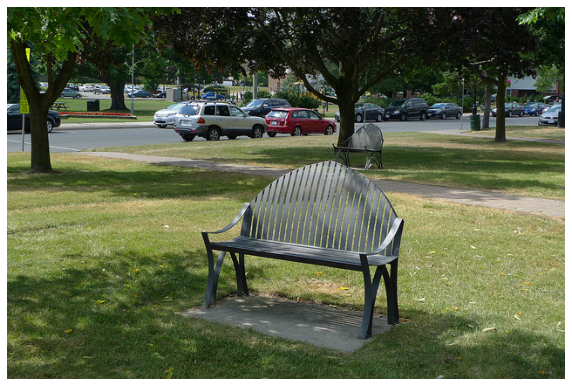

In [9]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_arr = cv2.imread('./mmdetection/demo/demo.jpg')

img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
plt.imshow(img_arr_rgb)
plt.axis('off')
plt.show()

In [10]:
# inference 수행하기
results = inference_detector(model, img_arr)

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/pyt

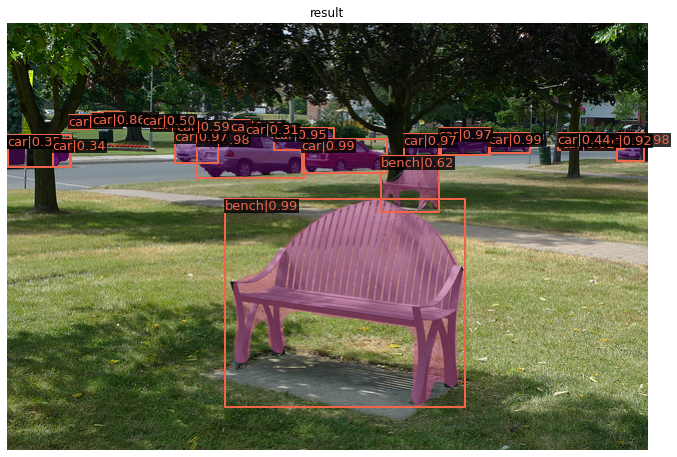

In [11]:
# Segmentation 수행 결과 확인
from mmdet.apis import show_result_pyplot

show_result_pyplot(model, img_arr, results)

### Inference 결과로 반환되는 results 값 살펴 보기
* inference_detector(model, img_path)의 결과로 반환되는 값은 instance segmentation 일 경우 Object Detection 결과에 추가되어 segmentation masking 정보도 함께 반환됨

* mmdetection에서 수행한 inference 모델의 Object Detection과는 다르게 해당 모델의 type은 튜플이고, 길이도 2가 되었다.

In [12]:
type(results), len(results)

(tuple, 2)

* 전체 Results의 결과

In [13]:
results

([array([[5.3380640e+02, 1.0804523e+02, 5.4053583e+02, 1.2511749e+02,
          9.9974260e-02]], dtype=float32),
  array([], shape=(0, 5), dtype=float32),
  array([[4.81508270e+02, 1.10576378e+02, 5.22668701e+02, 1.30030945e+02,
          9.90980089e-01],
         [2.94944916e+02, 1.16492393e+02, 3.79828735e+02, 1.50493469e+02,
          9.89214838e-01],
         [6.09770691e+02, 1.10475830e+02, 6.36041443e+02, 1.38237396e+02,
          9.83308971e-01],
         [1.84223339e-01, 1.12309631e+02, 6.32011375e+01, 1.44734009e+02,
          9.83204901e-01],
         [1.89931061e+02, 1.10189629e+02, 2.96254059e+02, 1.55370834e+02,
          9.80140746e-01],
         [4.31934601e+02, 1.05915459e+02, 4.82009277e+02, 1.32418304e+02,
          9.71464097e-01],
         [1.67749069e+02, 1.07459709e+02, 2.10424179e+02, 1.40552170e+02,
          9.65440154e-01],
         [3.96333038e+02, 1.11172188e+02, 4.33640747e+02, 1.33290237e+02,
          9.65018451e-01],
         [5.70615112e+02, 1.10114746e

* results는 bounding box와 confidence score로 이루어진 리스트들과 Object의 Masking이 합쳐져 1개의 튜플 자료형으로 출력되었다.
* 즉, results의 0번째는 기존에 수행한 Object Detection과 같은 결과를 반환하고, 1번째는 Mask predection을 통해 예측한 Masking 정보를 반환했다.
* 각각 출력하면 다음과 같다.

In [14]:
# 기존에 Object Detection에서 수행한 Bounding Box 정보와 Confidence Score
results[0]

[array([[5.3380640e+02, 1.0804523e+02, 5.4053583e+02, 1.2511749e+02,
         9.9974260e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[4.81508270e+02, 1.10576378e+02, 5.22668701e+02, 1.30030945e+02,
         9.90980089e-01],
        [2.94944916e+02, 1.16492393e+02, 3.79828735e+02, 1.50493469e+02,
         9.89214838e-01],
        [6.09770691e+02, 1.10475830e+02, 6.36041443e+02, 1.38237396e+02,
         9.83308971e-01],
        [1.84223339e-01, 1.12309631e+02, 6.32011375e+01, 1.44734009e+02,
         9.83204901e-01],
        [1.89931061e+02, 1.10189629e+02, 2.96254059e+02, 1.55370834e+02,
         9.80140746e-01],
        [4.31934601e+02, 1.05915459e+02, 4.82009277e+02, 1.32418304e+02,
         9.71464097e-01],
        [1.67749069e+02, 1.07459709e+02, 2.10424179e+02, 1.40552170e+02,
         9.65440154e-01],
        [3.96333038e+02, 1.11172188e+02, 4.33640747e+02, 1.33290237e+02,
         9.65018451e-01],
        [5.70615112e+02, 1.10114746e+02, 5.92991272e+02,

In [15]:
# Mask Prediction된 결과물
results[1]

[[array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])],
 [],
 [array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, Fal

In [16]:
print("0버째 결과 데이터 타입:",type(results[0]),
      "\n0번째 데이터의 Class 개수:",len(results[0]),
      "\n1번째 데이터의 타입:",type(results[1]), 
      "\n1번째 데이터의 Class 개수:",len(results[1]))

0버째 결과 데이터 타입: <class 'list'> 
0번째 데이터의 Class 개수: 80 
1번째 데이터의 타입: <class 'list'> 
1번째 데이터의 Class 개수: 80


In [17]:
print("result의 0번째 데이터 중 0번째 데이터의 타입:",type(results[0][0]), 
      "\n0번째 Detect된 데이터 모양:",results[0][0].shape, 
      "\n1번째 Detect된 데이터 모양:",results[0][1].shape, 
      "\n2번째 Detect된 데이터 모양:",results[0][2].shape)

result의 0번째 데이터 중 0번째 데이터의 타입: <class 'numpy.ndarray'> 
0번째 Detect된 데이터 모양: (1, 5) 
1번째 Detect된 데이터 모양: (0, 5) 
2번째 Detect된 데이터 모양: (45, 5)


In [44]:
print('results[1]의 첫번째 원소의 type과 size:', "\ntype:",type(results[1][0]), "size:",len(results[1][0]), '\n두번째 원소 사이즈:', len(results[1][1]), '\n세번째 원소 사이즈:', len(results[1][2]))
print()
print('results[1]의 첫번째 원소 list의 첫번째 원소 type과 shape:', "\ntype:",type(results[1][0][0]), "\nshape:",results[1][0][0].shape)
#print('results[1]의 두번째 원소 list의 첫번째 원소 type과 shape:', type(results[1][1][0]))
print()
print('results[1]의 세번째 원소 list의 첫번째/두번째/세번째 원소 shape:', results[1][2][0].shape, "/",results[1][2][1].shape, "/",results[1][2][2].shape)
print('image shape:', img_arr.shape)
print()
print("위의 결과랑 비교하면 사이즈는 행과 같고, mask 이미지의 모양은 원본 이미지와 같다는 것을 확인할 수 있다.")

results[1]의 첫번째 원소의 type과 size: 
type: <class 'list'> size: 1 
두번째 원소 사이즈: 0 
세번째 원소 사이즈: 45

results[1]의 첫번째 원소 list의 첫번째 원소 type과 shape: 
type: <class 'numpy.ndarray'> 
shape: (427, 640)

results[1]의 세번째 원소 list의 첫번째/두번째/세번째 원소 shape: (427, 640) / (427, 640) / (427, 640)
image shape: (416, 600, 3)

위의 결과랑 비교하면 사이즈는 행과 같고, mask 이미지의 모양은 원본 이미지와 같다는 것을 확인할 수 있다.


In [45]:
mask_imsi = results[1][0][0]
print("mask 이미지:\n",mask_imsi)
print()
print("0보다 큰 값의 개수:",mask_imsi[mask_imsi > 0].sum())
print("0의 개수:",(427 * 640) -72)

print("저체 이미지의 pixel중 Masking된 이미지의 개수는 72개이고, Masking 되지 않은 이미지의 개수는 427 * 640에서 72를 뺀 값이다.")

mask 이미지:
 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]

0보다 큰 값의 개수: 72
0의 개수: 273208
저체 이미지의 pixel중 Masking된 이미지의 개수는 72개이고, Masking 되지 않은 이미지의 개수는 427 * 640에서 72를 뺀 값이다.


### Masking 결과 시각화 해보기

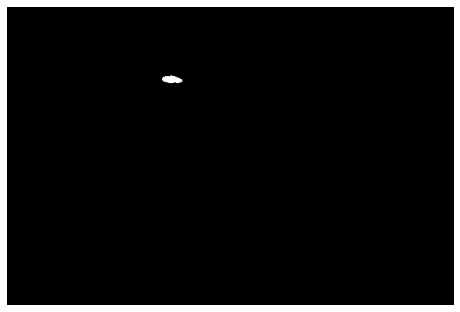

In [43]:
masking_img = results[1][2][40]

plt.figure(figsize=(8,8))
plt.imshow(masking_img, cmap = 'gray')
plt.axis('off')
plt.show()

### segmentation 시각화 함수 직접 작성 후 단일 이미지와 Video inference 수행.

* 데이터 다운로드

In [32]:
!mkdir data

In [33]:
# 이미지 다운로드
!wget -O ./data/traffic.jpg https://www.korea.kr/newsWeb/resources/attaches/2021.09/24/PYH2021092204100001300.jpg

# 동영상 다운로드(저작권이 없는 영상)
!wget -O ./data/traffic.mp4 https://github.com/Kang812/Object_Detection/raw/main/mmdet/data/traffic.mp4

--2021-10-05 00:24:07--  https://www.korea.kr/newsWeb/resources/attaches/2021.09/24/PYH2021092204100001300.jpg
Resolving www.korea.kr (www.korea.kr)... 27.101.217.76
Connecting to www.korea.kr (www.korea.kr)|27.101.217.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333317 (326K) [image/jpeg]
Saving to: ‘./data/traffic.jpg’

./data/traffic.jpg  100%[===================>] 325.50K   481KB/s    in 0.7s    

2021-10-05 00:24:10 (481 KB/s) - ‘./data/traffic.jpg’ saved [333317/333317]

--2021-10-05 00:24:11--  https://github.com/Kang812/Object_Detection/raw/main/mmdet/data/traffic.mp4
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Kang812/Object_Detection/main/mmdet/data/traffic.mp4 [following]
--2021-10-05 00:24:11--  https://raw.githubusercontent.com/Kang812/Object_Detection/main/mmdet/data/traffi

### Color list와 label seq 작성

In [20]:
# 0부터 순차적으로 클래스 매핑된 label 적용. 
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [21]:
# model -> roi_head -> test_cfg -> mask_thr_binary가 0.5로 지정되어져 있어
# 입력된 pixel 값이 0보다 크면 masking 정보 아니면 배경으로 분류하기 위한 threshold가 정해져 있음
# 추후 config 파일을 설정을 통해서 조정가능
print(model.cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

* Bounding Box를 치는 것은 기존과 동일

In [22]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성. 
# 이미 inference 시 mask boolean값이 들어오므로 mask_threshold 값을 필요하지 않음.
import numpy as np

def get_detected_img(model, img_array, score_threshold = 0.3, is_print = True):
    
    draw_img = img_array.copy()
    bbox_color = (0, 255, 0)
    text_color = (0, 0, 255)
    
    results = inference_detector(model, img_array)
    bbox_results = results[0]
    seg_results = results[1]
    
    for result_ind, bbox_result in enumerate(bbox_results):
        
        if len(bbox_result) == 0:
            continue
        
        mask_array_list = seg_results[result_ind]
        
        for i in range(len(bbox_result)):
            if bbox_result[i,4] > score_threshold:
                left = int(bbox_result[i,0])
                top = int(bbox_result[i,1])
                right = int(bbox_result[i,2])
                bottom = int(bbox_result[i,3])
                
                caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i,4])
                cv2.rectangle(draw_img, (left, top), (right, bottom), bbox_color, thickness = 2)
                cv2.putText(draw_img, caption, (left, top - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
                
                class_mask_array = mask_array_list[i]

                # masking된 영역만 추출
                # 즉, True에 해당되는 영역만 추출
                mask_roi = draw_img[class_mask_array]
                
                # 랜덤하게 Masking 할 색을 얻기 위한 코드
                # np.random.randint를 이용해 0 ~~ 9 사이의 값을 랜덤하게 출력
                # 여기서 np.random.randint에서 얻은 값은 colors의 index 값이고, 해당 index 값을 이용해서 colors에서 랜덤한 색 정보를 얻어 올 수 있다.
                # 만약 80개의 색을 설정하면 Label 마다 Matching되는 색을 얻어 오는 것도 가능하다.
                # 각 Label에 맞는 색을 가져 올때는 랜덤을 사용하지 않고, 'result_ind'를 이용해서 colors[result_ind]를 사용해서 색을 가져온다.
                color_index = np.random.randint(0, len(colors)-1)
                color = colors[color_index]
                
                # 마스크의 투명도 설정
                # masking된 영역만 추출을 통해서 해당 영역에 대한 Masking 정보를 투명하게 설정
                draw_img[class_mask_array] = ([0.3 * color[0], 0.3 * color[1], 0.3 * color[2]] + 0.6 * mask_roi).astype(np.uint8)
                
                if is_print:
                    print(caption)
    return draw_img

In [24]:
img_arr = cv2.imread('./mmdetection/demo/demo.jpg')

mask_array = results[1][2][0]
print('image array shape:', img_arr.shape)
print('mask array shape:', mask_array.shape)
print('mask true array shape:', mask_array[mask_array].shape)
print('masked array shape:', img_arr[results[1][2][0]].shape)

image array shape: (427, 640, 3)
mask array shape: (427, 640)
mask true array shape: (628,)
masked array shape: (628, 3)


/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


car: 0.9910
car: 0.9892
car: 0.9833
car: 0.9832
car: 0.9801
car: 0.9715
car: 0.9654
car: 0.9650
car: 0.9546
car: 0.9531
car: 0.9524
car: 0.9464
car: 0.9209
car: 0.9160
car: 0.8646
car: 0.6161
car: 0.5985
car: 0.5947
car: 0.5020
car: 0.4424
car: 0.3456
car: 0.3411
car: 0.3080
bench: 0.9872
bench: 0.6239


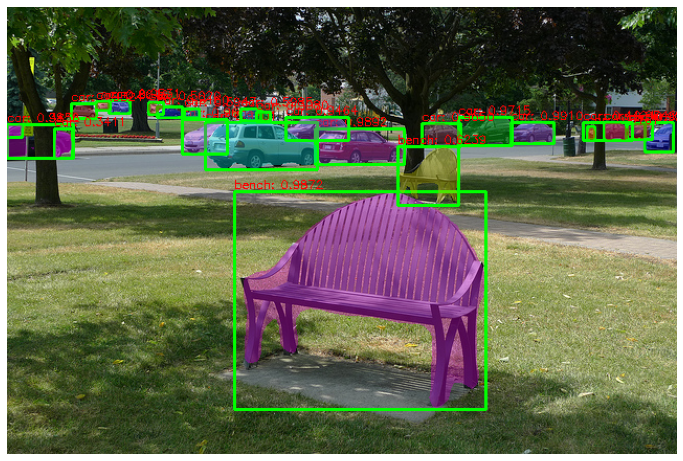

In [25]:
detected_img = get_detected_img(model, img_arr, score_threshold=0.3, is_print=True)
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (12,12))
plt.imshow(detected_img)
plt.axis('off')
plt.show()

* 다른 이미지 사용

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


car: 0.9883
car: 0.9872
car: 0.9741
car: 0.9740
car: 0.9729
car: 0.9604
car: 0.9601
car: 0.9497
car: 0.9428
car: 0.9318
car: 0.9155
car: 0.9134
car: 0.9041
car: 0.8996
car: 0.8959
car: 0.8691
car: 0.8685
car: 0.8671
car: 0.8425
car: 0.8224
car: 0.8042
car: 0.7826
car: 0.7542
car: 0.7384
car: 0.7335
car: 0.7147
car: 0.6996
car: 0.6932
car: 0.6586
car: 0.6446
car: 0.6331
car: 0.5948
car: 0.5839
car: 0.5807
car: 0.5709
car: 0.5586
car: 0.5475
car: 0.5374
car: 0.5130
car: 0.5122
car: 0.5062
car: 0.4978
car: 0.4897
car: 0.4847
car: 0.4551
car: 0.4445
car: 0.4403
car: 0.4377
car: 0.4078
car: 0.3942
car: 0.3941
car: 0.3896
car: 0.3896
car: 0.3813
car: 0.3767
car: 0.3674
car: 0.3648
car: 0.3430
car: 0.3309
car: 0.3258
car: 0.3255
car: 0.3079
car: 0.3050
bus: 0.8215
bus: 0.7028
bus: 0.5978
bus: 0.3399
bus: 0.3145
truck: 0.9351
truck: 0.4937
truck: 0.4160
truck: 0.3432


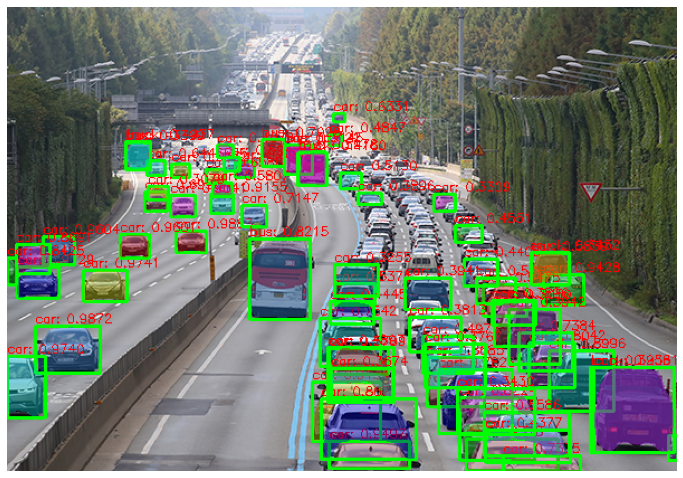

In [28]:
img_arr = cv2.imread('./data/traffic.jpg')

detected_img = get_detected_img(model, img_arr, score_threshold=0.3, is_print=True)
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (12,12))
plt.imshow(detected_img)
plt.axis('off')
plt.show()

In [34]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print = True):
    
    cap = cv2.VideoCapture(input_path)
    
    codec = cv2.VideoWriter_fourcc(*"XVID")
    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    
    vid_witer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("총 Frame 갯수:", frame_cnt)
    
    btime = time.time()
    
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,score_threshold= score_threshold, is_print=False)
        
        if do_print:
            print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        
        vid_witer.write(img_frame)
    vid_witer.release()
    cap.release()
    
    print("최종 Detection 완료 수행 시간:", round(time.time() - btime,4))

In [35]:
do_detected_video(model, "./data/traffic.mp4", "./data/traffic_output_01.mp4", score_threshold=0.3, do_print=True)

총 Frame 갯수: 154


/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


frame별 detection 수행 시간: 1.2322
frame별 detection 수행 시간: 1.1921
frame별 detection 수행 시간: 1.1467
frame별 detection 수행 시간: 1.12
frame별 detection 수행 시간: 1.0976
frame별 detection 수행 시간: 1.064
frame별 detection 수행 시간: 1.0569
frame별 detection 수행 시간: 1.0834
frame별 detection 수행 시간: 1.1049
frame별 detection 수행 시간: 1.125
frame별 detection 수행 시간: 1.0709
frame별 detection 수행 시간: 1.1179
frame별 detection 수행 시간: 1.1193
frame별 detection 수행 시간: 1.1462
frame별 detection 수행 시간: 1.1481
frame별 detection 수행 시간: 1.1564
frame별 detection 수행 시간: 1.1534
frame별 detection 수행 시간: 1.1045
frame별 detection 수행 시간: 1.1413
frame별 detection 수행 시간: 1.0846
frame별 detection 수행 시간: 1.1955
frame별 detection 수행 시간: 1.1858
frame별 detection 수행 시간: 1.2198
frame별 detection 수행 시간: 1.2073
frame별 detection 수행 시간: 1.1637
frame별 detection 수행 시간: 1.1688
frame별 detection 수행 시간: 1.2002
frame별 detection 수행 시간: 1.241
frame별 detection 수행 시간: 1.1871
frame별 detection 수행 시간: 1.1666
frame별 detection 수행 시간: 1.1595
frame별 detection 수행 시간: 1.2055
frame별 detect